In [1]:
import numpy as np
import pandas as pd
import os
from PIL import Image

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, mean_squared_error
from sklearn.manifold import TSNE


In [2]:
def load_dataset(directory=r'C:\Users\sahil\Desktop\DataScience\att_faces'):
   
    images = []
    labels = []
    for i in range(1, 41): 
        subject_dir = os.path.join(directory, f's{i}')
        for j in range(1, 11):  
            img_path = os.path.join(subject_dir, f'{j}.pgm')
            with Image.open(img_path) as img:
                images.append(np.array(img, dtype=np.uint8).flatten())
                labels.append(i - 1) 
    return np.array(images), np.array(labels)


X, y = load_dataset()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

In [3]:
X_train.shape

(320, 10304)

In [8]:
y_train

array([13,  5,  3, 12, 10, 20, 24, 35, 11, 13,  1,  9, 20, 37,  1, 20, 35,
       32, 36, 33, 16, 33, 19,  7, 23, 33, 10, 36, 19, 13, 15, 22, 34, 12,
        8,  0,  8, 34, 32, 28, 34,  6,  3, 31, 21, 21, 38, 13,  8, 12, 25,
       34,  5, 26, 33, 16,  4, 37, 20, 35, 20,  8,  3,  6,  9, 30,  4, 31,
       18,  0, 16,  9, 25, 37, 18, 38,  1, 10, 39,  5, 31, 24,  7, 28, 14,
       32, 33, 25,  3, 31, 39, 32, 10, 30, 18,  9,  3,  8,  1, 24, 31,  7,
       15, 22, 39, 28,  7, 16, 24, 26, 20, 26, 26, 39,  3, 17, 16, 26, 27,
       29, 30, 14, 32, 38, 25, 36, 38, 21, 36, 34, 30, 19,  2, 28,  9, 29,
       27, 16, 13, 14, 38, 24,  0, 28, 10,  4, 16, 39, 38, 29, 17, 25,  5,
        5,  9,  8,  8,  1, 22, 28, 29, 27, 18, 10, 19, 37,  0,  9,  2, 25,
        0, 24, 33, 26, 29, 17, 26, 22, 25,  1, 27, 32,  4, 12, 35, 10, 35,
       31, 35, 30, 25,  3, 23, 10, 22, 29, 19,  9, 24, 11,  2,  8, 37, 23,
       23,  1, 28, 30, 11,  5, 14, 15, 11,  4,  0, 15, 28, 16, 17, 17, 36,
        2,  7, 14, 27, 11

In [4]:
X_test.shape

(80, 10304)

In [5]:
def pca(X, k):
    X_mean = np.mean(X, axis=0)
    X_centered = X - X_mean

    cov_matrix = np.dot(X_centered.T, X_centered) / (X_centered.shape[0] - 1)

    eig_vals, eig_vecs = np.linalg.eigh(cov_matrix)

    idx = np.argsort(eig_vals)[::-1]
    eig_vals = eig_vals[idx]
    eig_vecs = eig_vecs[:, idx]

    U_k = eig_vecs[:, :k]

    X_train_proj = X_centered @ U_k

    X_train_recon = X_train_proj @ U_k.T + X_mean

    return X_train_proj, X_train_recon, U_k, X_mean


In [6]:
def project(X_test, U_k, X_mean):
    X_test_centered = X_test - X_mean
    X_test_proj = X_test_centered @ U_k
    X_test_recon = X_test_proj @ U_k.T + X_mean
    return X_test_proj, X_test_recon


In [7]:
def predict_label(X_train_recon, y_train, X_test_recon):
    y_pred = []
    for xt in X_test_recon:
        distances = np.linalg.norm(X_train_recon - xt, axis=1)
        nearest_idx = np.argmin(distances)
        y_pred.append(y_train[nearest_idx])
    return np.array(y_pred)

k=1: Accuracy=7.50%, Reconstruction Error=8.41%
k=5: Accuracy=87.50%, Reconstruction Error=5.32%
k=10: Accuracy=95.00%, Reconstruction Error=4.08%
k=15: Accuracy=95.00%, Reconstruction Error=3.46%
k=20: Accuracy=95.00%, Reconstruction Error=3.02%
k=50: Accuracy=96.25%, Reconstruction Error=1.80%
k=100: Accuracy=95.00%, Reconstruction Error=1.00%
k=200: Accuracy=95.00%, Reconstruction Error=0.32%
k=300: Accuracy=95.00%, Reconstruction Error=0.03%
k=400: Accuracy=95.00%, Reconstruction Error=0.00%


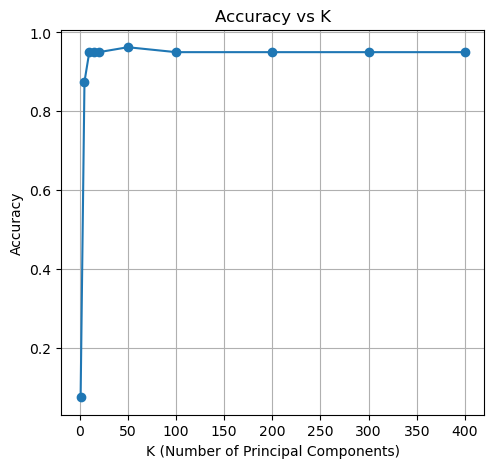

In [9]:
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
import numpy as np
accuracy_list = []
recon_error_list = []
k_list = [1,5,10,15,20,50,100,200,300,400 ]
for k in k_list:
    X_train_proj, X_train_recon, U_k, X_mean = pca(X_train, k)
    X_test_proj, X_test_recon = project(X_test, U_k, X_mean)
    y_pred = predict_label(X_train_recon, y_train, X_test_recon)
    acc = accuracy_score(y_test, y_pred)
    accuracy_list.append(acc)
    error = np.linalg.norm(X_train - X_train_recon, 'fro')**2 / np.linalg.norm(X_train, 'fro')**2 * 100
    recon_error_list.append(error)
    print(f"k={k}: Accuracy={acc*100:.2f}%, Reconstruction Error={error:.2f}%") 

plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
plt.plot(k_list, accuracy_list, marker='o')
plt.title("Accuracy vs K")
plt.xlabel("K (Number of Principal Components)")
plt.ylabel("Accuracy")
plt.grid(True)

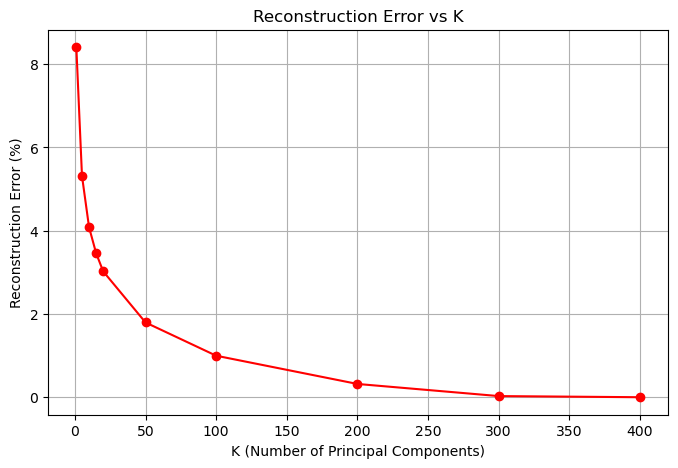

In [10]:
import matplotlib.pyplot as plt

# Assuming k_list and recon_error_list are already defined
plt.figure(figsize=(8,5))
plt.plot(k_list, recon_error_list, marker='o', color='r')
plt.title("Reconstruction Error vs K")
plt.xlabel("K (Number of Principal Components)")
plt.ylabel("Reconstruction Error (%)")
plt.grid(True)
plt.show()
